In [1]:
# Перевірка наявності та стану GPU
!nvidia-smi

Sun May 25 14:53:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Встановлення бібліотек
!pip install ultralytics "roboflow>=0.2.28" supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56

In [11]:
import os
import torch # PyTorch, на якому працює YOLOv8
from roboflow import Roboflow
from google.colab import userdata # Для безпечного доступу до API ключа
import supervision as sv # Імпортуємо supervision для майбутнього використання

# Перевірка версії PyTorch та доступності CUDA (для GPU)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")

# Перевірка Ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.9/112.6 GB disk)


In [4]:
# Отримання API ключа з секретів Colab
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

# Ініціалізація Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
WORKSPACE_ID = "jeremy-fhjar"
PROJECT_ID = "ground-military-transport-recognition"
VERSION_NUMBER = 2

# Отримання доступу до проекту та завантаження датасету
# Ми вказуємо format="yolov8", щоб Roboflow експортував датасет у форматі,
# сумісному з YOLOv8 (включаючи файл data.yaml)
project = rf.workspace(WORKSPACE_ID).project(PROJECT_ID)
dataset = project.version(VERSION_NUMBER).download("yolov8")

# Виведемо розташування завантаженого датасету
print(f"Розташування датасету: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Ground-Military-Transport-Recognition-2 in yolov8:: 100%|██████████| 9364/9364 [00:01<00:00, 6736.89it/s]


Розташування датасету: /content/Ground-Military-Transport-Recognition-2


In [5]:
# Показати вміст папки з датасетом
!ls {dataset.location}

# Показати вміст файлу data.yaml
!cat {dataset.location}/data.yaml

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid
names:
- artillery
- military_truck
- military_vehicle
- tank
nc: 4
roboflow:
  license: CC BY 4.0
  project: ground-military-transport-recognition
  url: https://universe.roboflow.com/jeremy-fhjar/ground-military-transport-recognition/dataset/2
  version: 2
  workspace: jeremy-fhjar
test: ../test/images
train: ../train/images
val: ../valid/images


In [6]:
import yaml # Бібліотека для роботи з YAML файлами

# Шлях до файлу data.yaml
data_yaml_path = os.path.join(dataset.location, "data.yaml")

# Читаємо вміст data.yaml
with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

# Встановлюємо абсолютний шлях до кореневої папки датасету
data_config['path'] = os.path.abspath(dataset.location)

# Коригуємо шляхи до навчальної, валідаційної та тестової вибірок
# Вони мають бути відносними до значення 'path' (тобто, від кореня датасету)
data_config['train'] = 'train/images'  # Було ../train/images
data_config['val'] = 'valid/images'    # Було ../valid/images

# Перевіряємо, чи є ключ 'test' і коригуємо його, якщо він існує
if 'test' in data_config and isinstance(data_config['test'], str):
    data_config['test'] = 'test/images' # Було ../test/images
elif 'test' not in data_config:
    print("Ключ 'test' відсутній у data.yaml, пропускаємо його корекцію.")

# Зберігаємо виправлений data.yaml
with open(data_yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print("\nВиправлений вміст data.yaml:")
!cat {data_yaml_path}


Виправлений вміст data.yaml:
names:
- artillery
- military_truck
- military_vehicle
- tank
nc: 4
path: /content/Ground-Military-Transport-Recognition-2
roboflow:
  license: CC BY 4.0
  project: ground-military-transport-recognition
  url: https://universe.roboflow.com/jeremy-fhjar/ground-military-transport-recognition/dataset/2
  version: 2
  workspace: jeremy-fhjar
test: test/images
train: train/images
val: valid/images


In [7]:
# Параметри для навчання моделі
MODEL_NAME = "yolov8s.pt" # YOLOv8s (small)
EPOCHS = 50               # Кількість епох для навчання
IMG_SIZE = 640            # Розмір зображень (ми готували датасет до 640x640)
BATCH_SIZE = 16           # Розмір батчу. 16 має бути нормально для Tesla T4 з yolov8s

# Шлях до нашого виправленого файлу data.yaml
# dataset.location був визначений при завантаженні датасету
DATA_YAML_PATH = os.path.join(dataset.location, "data.yaml")

PROJECT_NAME = "Military_Vehicle_Detection_Runs" # Назва проекту для збереження результатів навчання
DATASET_VERSION_NUMBER = 2 # Номер версії датасету
# Назва конкретного запуску навчання
RUN_NAME = f"{MODEL_NAME.split('.')[0]}_epochs{EPOCHS}_batch{BATCH_SIZE}_datasetV{DATASET_VERSION_NUMBER}"

print(f"Модель: {MODEL_NAME}")
print(f"Кількість епох: {EPOCHS}")
print(f"Розмір зображення: {IMG_SIZE}")
print(f"Розмір батчу: {BATCH_SIZE}")
print(f"Шлях до data.yaml: {DATA_YAML_PATH}")
print(f"Проект: {PROJECT_NAME}")
print(f"Запуск: {RUN_NAME}")

Модель: yolov8s.pt
Кількість епох: 50
Розмір зображення: 640
Розмір батчу: 16
Шлях до data.yaml: /content/Ground-Military-Transport-Recognition-2/data.yaml
Проект: Military_Vehicle_Detection_Runs
Запуск: yolov8s_epochs50_batch16_datasetV2


In [8]:
# Запуск навчання
!yolo task=detect mode=train \
      model={MODEL_NAME} \
      data="{DATA_YAML_PATH}" \
      epochs={EPOCHS} \
      imgsz={IMG_SIZE} \
      batch={BATCH_SIZE} \
      project="{PROJECT_NAME}" \
      name="{RUN_NAME}" \
      patience=20 # Кількість епох без покращення, після яких навчання зупиниться

100% 21.5M/21.5M [00:00<00:00, 288MB/s]
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Ground-Military-Transport-Recognition-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_epochs50_batch16_datasetV2, nbs=64, nms=False, opset=None, optimize=False, 

Результати збережено у папці: Military_Vehicle_Detection_Runs/yolov8s_epochs50_batch16_datasetV2
args.yaml			 R_curve.png	      train_batch8202.jpg
confusion_matrix_normalized.png  results.csv	      val_batch0_labels.jpg
confusion_matrix.png		 results.png	      val_batch0_pred.jpg
F1_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
labels_correlogram.jpg		 train_batch1.jpg     val_batch1_pred.jpg
labels.jpg			 train_batch2.jpg     val_batch2_labels.jpg
P_curve.png			 train_batch8200.jpg  val_batch2_pred.jpg
PR_curve.png			 train_batch8201.jpg  weights

Графіки навчання (results.png):


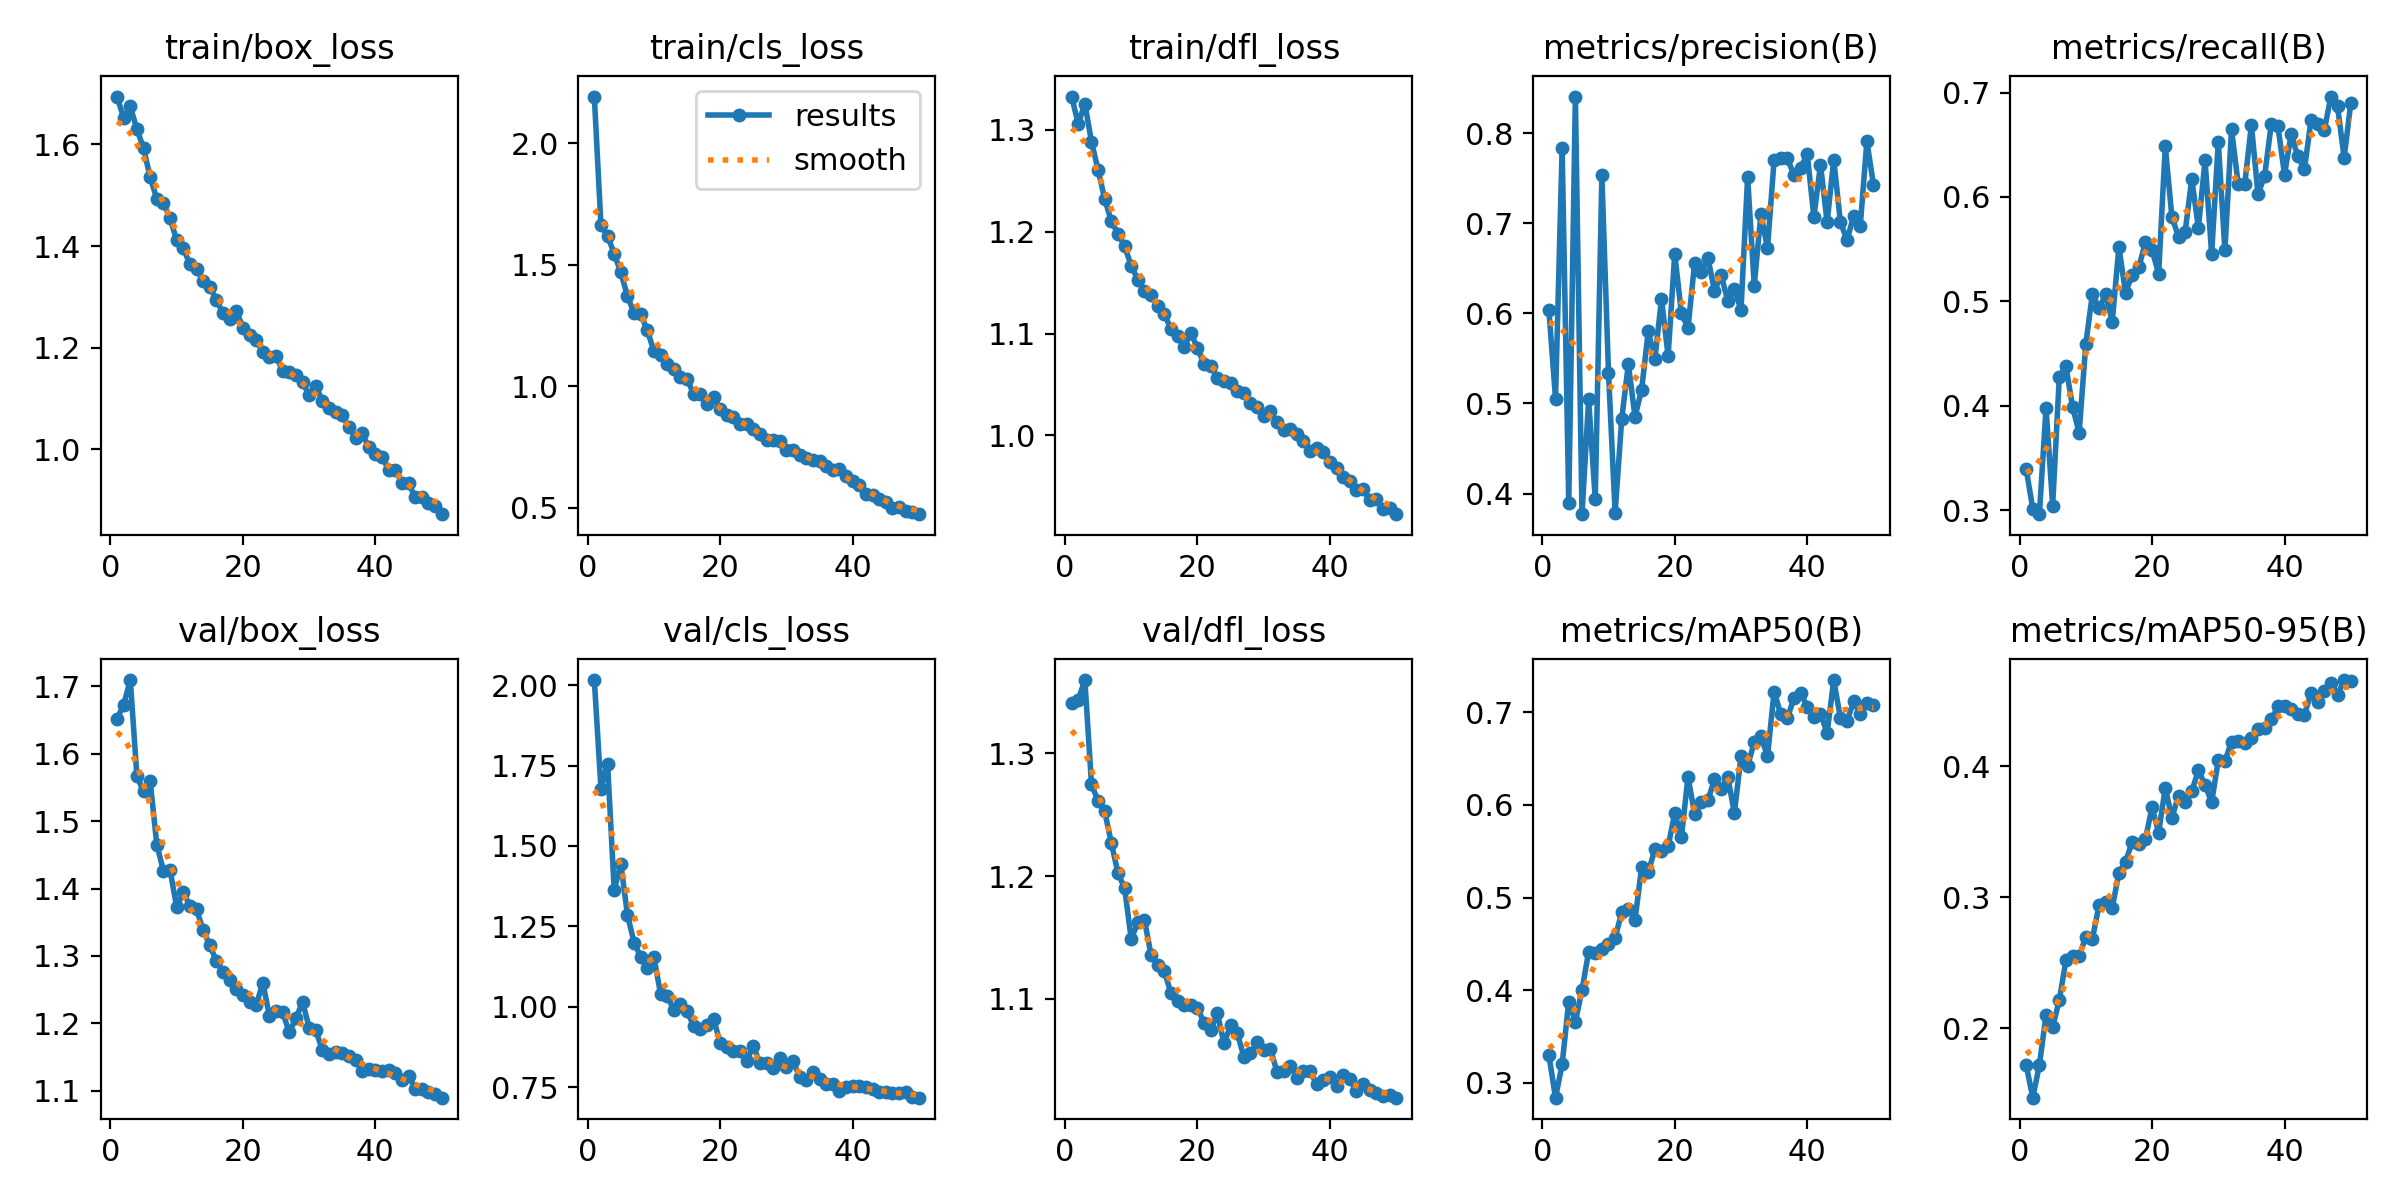


Матриця помилок (confusion_matrix.png):


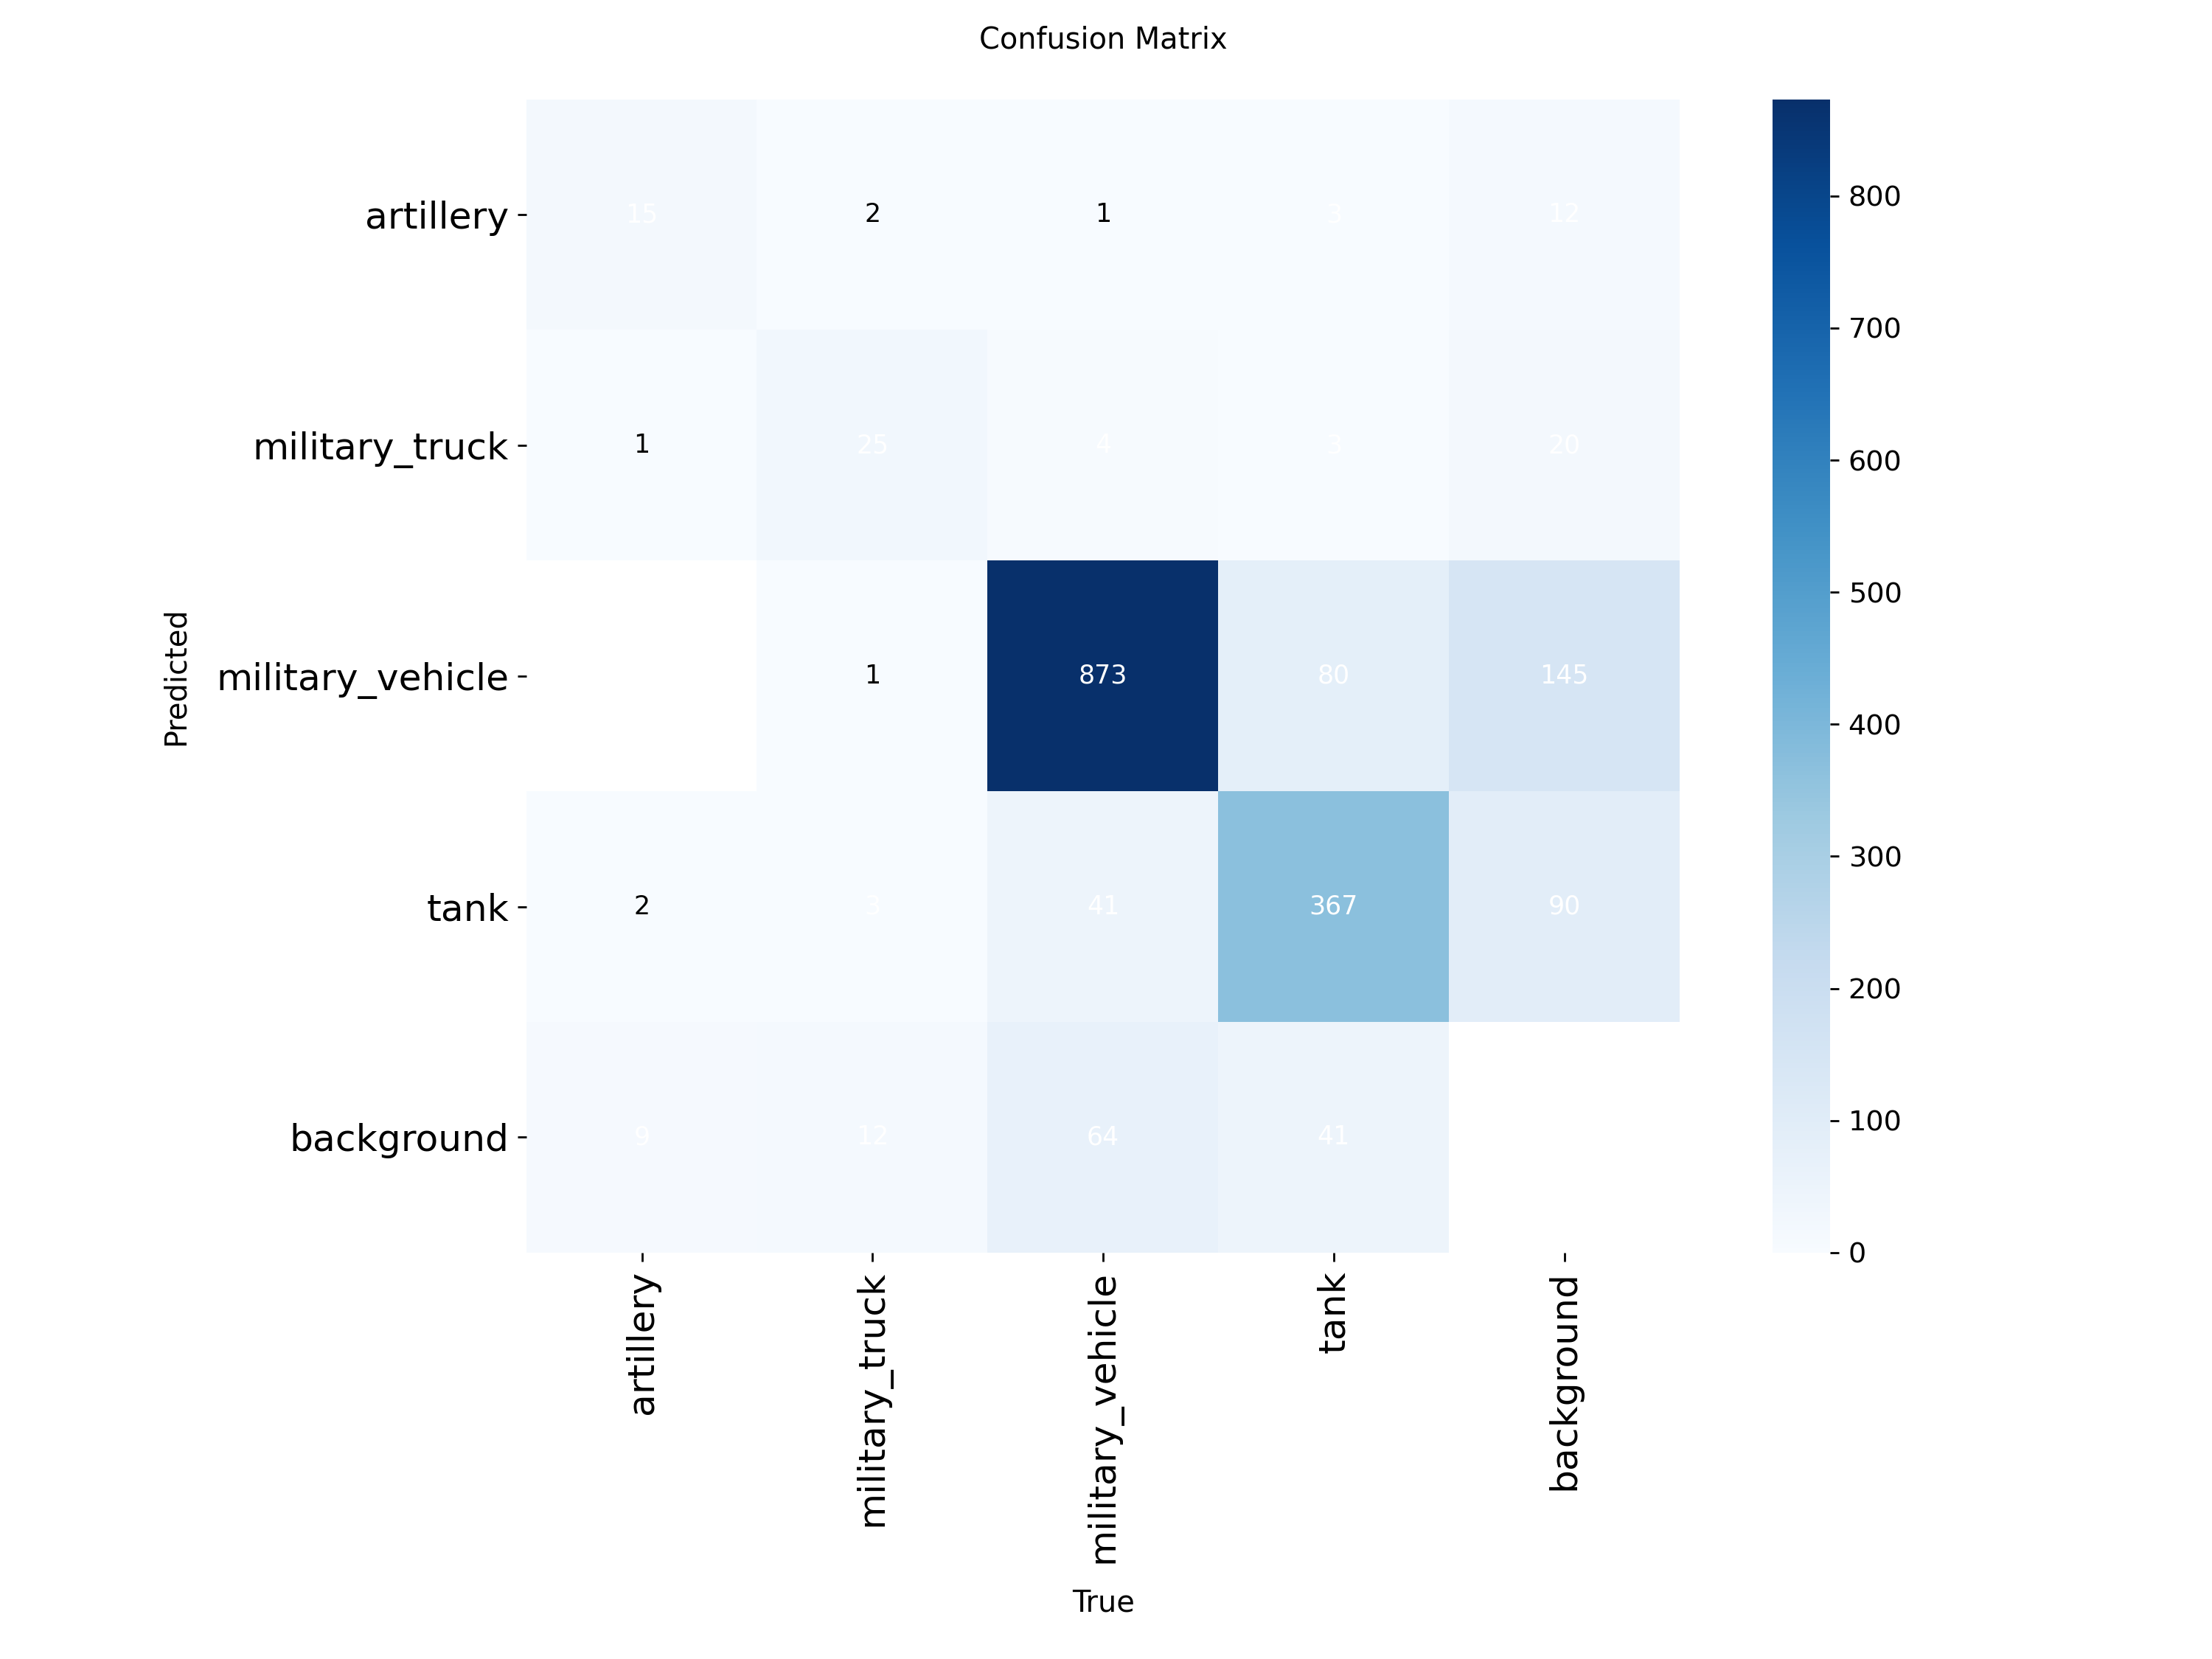


Нормалізована матриця помилок (confusion_matrix_normalized.png):


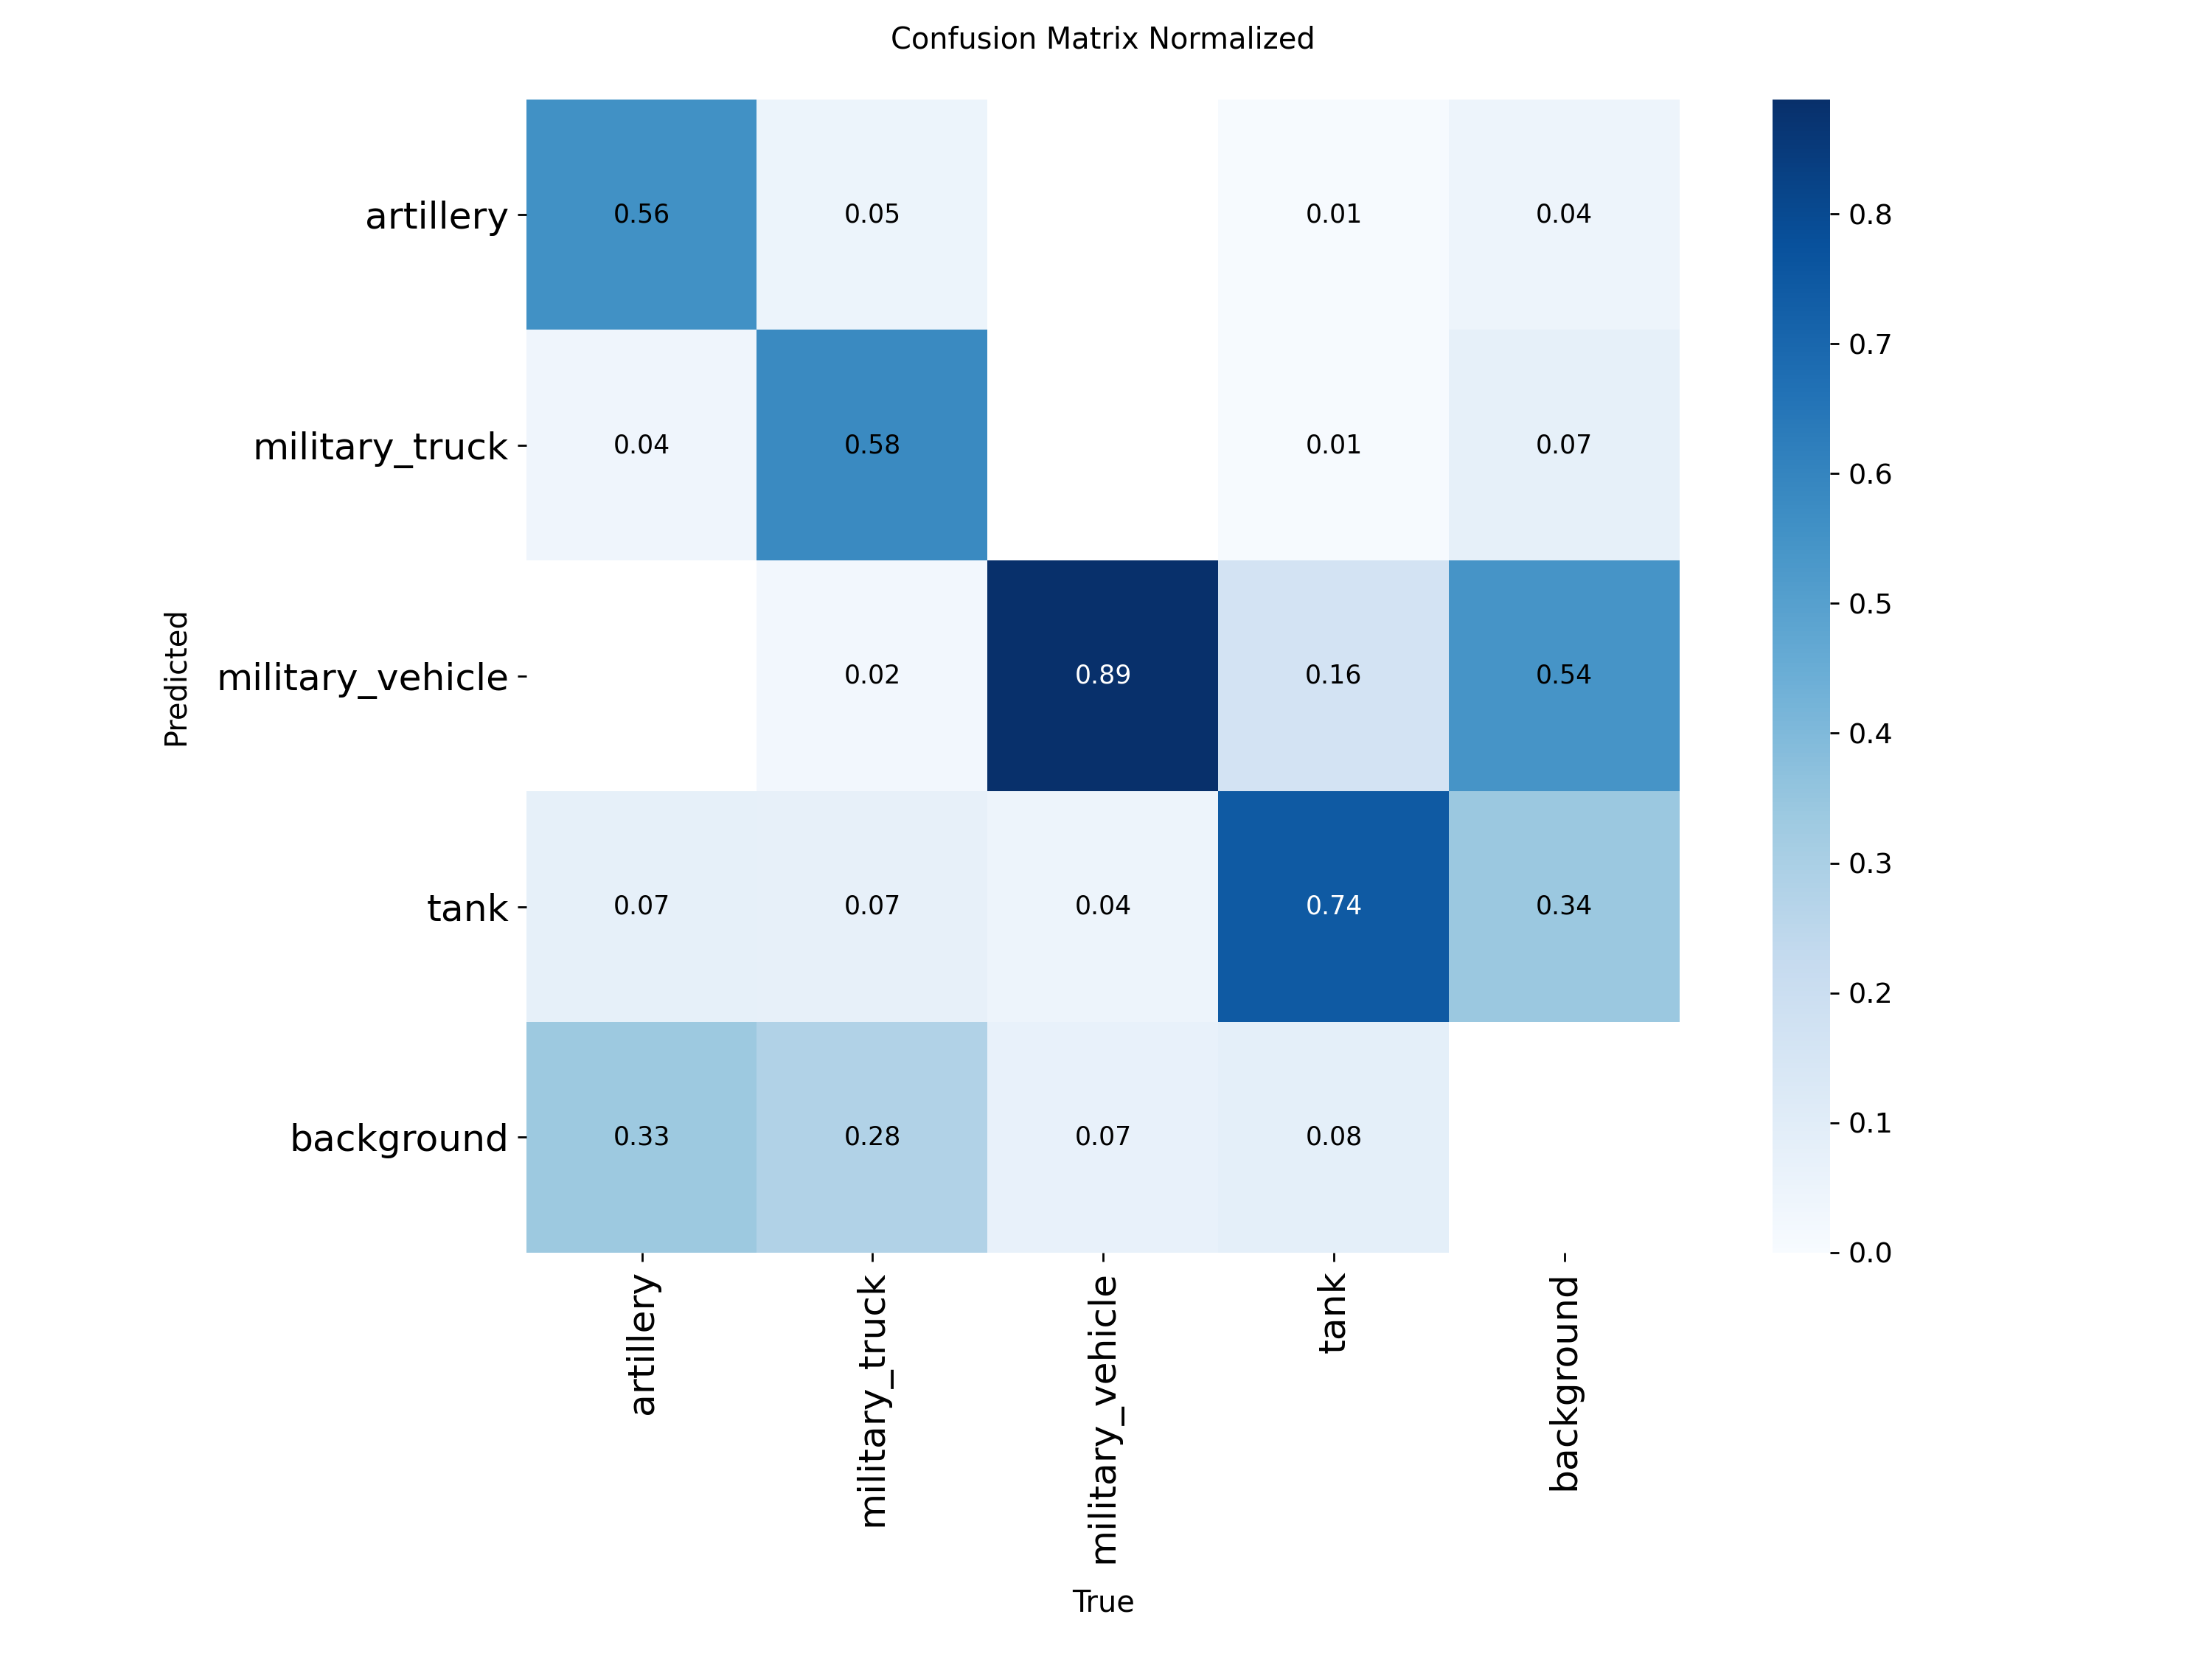


Приклади розпізнавання на валідаційному батчі (val_batch0_pred.jpg):


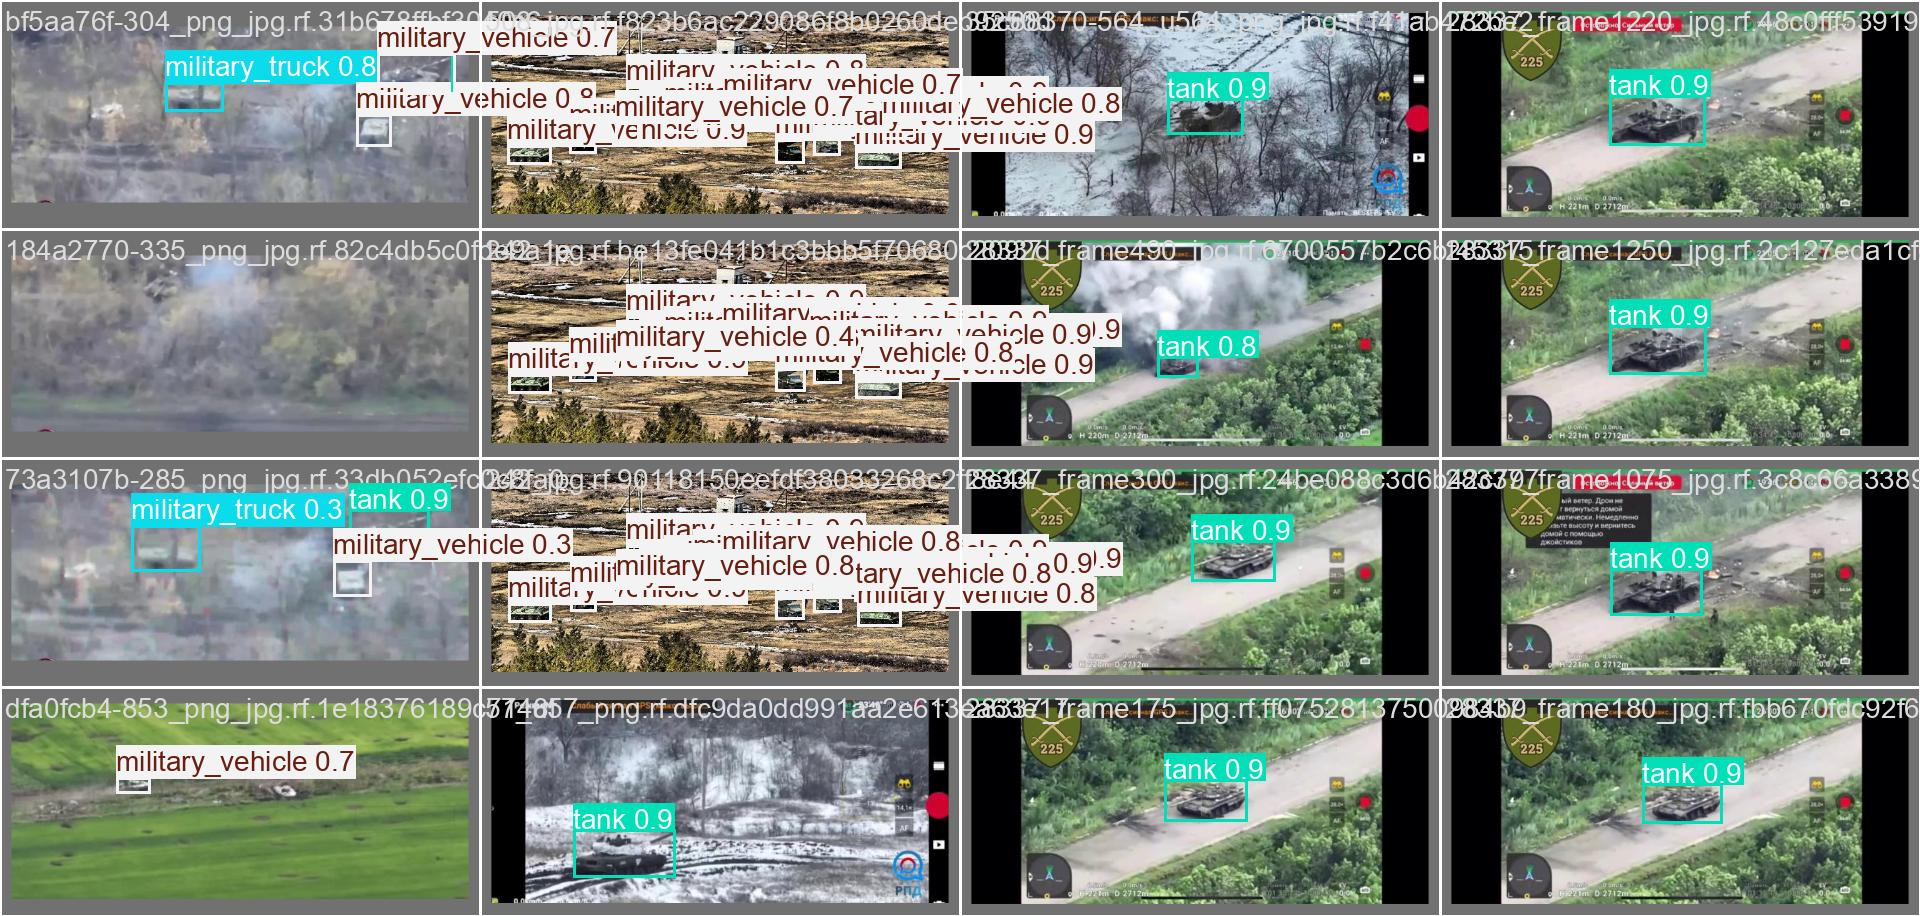


Збережені ваги моделі знаходяться у: Military_Vehicle_Detection_Runs/yolov8s_epochs50_batch16_datasetV2/weights/
best.pt  last.pt


In [12]:
import glob # Для пошуку файлів
from IPython.display import Image, display

# Формуємо шлях до папки з результатами
results_path = os.path.join(PROJECT_NAME, RUN_NAME)
print(f"Результати збережено у папці: {results_path}")

# Виводимо вміст папки з результатами
!ls {results_path}

# Відображаємо ключові графіки:

# Графіки навчання (втрати, метрики)
if os.path.exists(os.path.join(results_path, 'results.png')):
    print("\nГрафіки навчання (results.png):")
    display(Image(filename=os.path.join(results_path, 'results.png'), width=800))
else:
    print("\nФайл results.png не знайдено.")

# Матриця помилок (confusion matrix)
if os.path.exists(os.path.join(results_path, 'confusion_matrix.png')):
    print("\nМатриця помилок (confusion_matrix.png):")
    display(Image(filename=os.path.join(results_path, 'confusion_matrix.png'), width=600))
else:
    print("\nФайл confusion_matrix.png не знайдено.")

# Матриця помилок з нормалізацією (якщо є)
if os.path.exists(os.path.join(results_path, 'confusion_matrix_normalized.png')):
    print("\nНормалізована матриця помилок (confusion_matrix_normalized.png):")
    display(Image(filename=os.path.join(results_path, 'confusion_matrix_normalized.png'), width=600))
else:
    print("\nФайл confusion_matrix_normalized.png не знайдено.")

# Приклади розпізнавання на валідаційному батчі
# YOLOv8 зберігає кілька таких батчів, ми виводимо перший
validation_batch_images = sorted(glob.glob(os.path.join(results_path, 'val_batch*_pred.jpg')))
if validation_batch_images:
    print(f"\nПриклади розпізнавання на валідаційному батчі ({os.path.basename(validation_batch_images[0])}):")
    display(Image(filename=validation_batch_images[0], width=800))
else:
    print("\nФайли val_batch*_pred.jpg не знайдено.")

# Також важливими є збережені ваги моделі, які знаходяться в папці results_path/weights/
# Зазвичай це best.pt (найкраща модель за метриками на валідації) та last.pt (модель з останньої епохи)
print(f"\nЗбережені ваги моделі знаходяться у: {os.path.join(results_path, 'weights/')}")
!ls {os.path.join(results_path, 'weights/')}

In [13]:
# Шлях до найкращих ваг моделі
path_to_best_weights = os.path.join(PROJECT_NAME, RUN_NAME, 'weights/best.pt')

# Перевіряємо, чи існує файл data.yaml і чи є в ньому шлях до тестової вибірки
data_yaml_path = os.path.join(dataset.location, "data.yaml")
test_split_defined = False
try:
    with open(data_yaml_path, 'r') as f:
        data_cfg = yaml.safe_load(f)
        if 'test' in data_cfg and data_cfg['test']:
            test_split_defined = True
            print(f"Тестова вибірка визначена у data.yaml: {data_cfg['test']}")
        else:
            print("Шлях до тестової вибірки не визначений або порожній у data.yaml.")
except Exception as e:
    print(f"Помилка читання data.yaml: {e}")

if os.path.exists(path_to_best_weights) and test_split_defined:
    print(f"\nЗапуск оцінки на тестовій вибірці з вагами: {path_to_best_weights}")
    !yolo task=detect mode=val \
          model="{path_to_best_weights}" \
          data="{data_yaml_path}" \
          split=test \
          name="{RUN_NAME}_test_evaluation" \
          project="{PROJECT_NAME}" \
          imgsz={IMG_SIZE}
else:
    if not os.path.exists(path_to_best_weights):
        print(f"Помилка: Файл ваг {path_to_best_weights} не знайдено!")
    if not test_split_defined:
        print("Оцінка на тестовій вибірці неможлива без визначеного шляху 'test' у data.yaml.")

Тестова вибірка визначена у data.yaml: test/images

Запуск оцінки на тестовій вибірці з вагами: Military_Vehicle_Detection_Runs/yolov8s_epochs50_batch16_datasetV2/weights/best.pt
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1131.8±260.3 MB/s, size: 25.8 KB)
val: Scanning /content/Ground-Military-Transport-Recognition-2/test/labels.cache... 700 images, 0 backgrounds, 0 corrupt: 100% 700/700 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 54, len(boxes) = 1565. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 44/44 [00:07<00:00,  5.67it/s]
                   all

In [25]:
# Розпізнавання об'єктів на відео.
# Шлях до моделі
try:
    PATH_TO_MODEL_FOR_VIDEO = os.path.join(PROJECT_NAME, RUN_NAME, 'weights/best.pt')
    if not os.path.exists(PATH_TO_MODEL_FOR_VIDEO):
        raise FileNotFoundError(f"Модель: {PATH_TO_MODEL_FOR_VIDEO} не знайдено.")
    print(f"Модель: {PATH_TO_MODEL_FOR_VIDEO}")
except NameError:
    print("ПОМИЛКА: PROJECT_NAME/RUN_NAME не визначені.")
    raise

# Вхідне відео (має бути .mp4 у /content/test_video/)
VIDEO_FILENAME_INPUT_MP4 = "test_video_1.mp4"
PATH_TO_YOUR_VIDEO = os.path.join("/content/Test_Video/", VIDEO_FILENAME_INPUT_MP4)

if not os.path.exists(PATH_TO_YOUR_VIDEO):
    raise FileNotFoundError(f"Вхідне відео: {PATH_TO_YOUR_VIDEO} не знайдено. Завантажте його у /content/test_video/")
print(f"Вхідне відео: {PATH_TO_YOUR_VIDEO}")

# Параметри та запуск predict
CONFIDENCE_THRESHOLD = 0.30
VIDEO_OUTPUT_PROJECT = "Test_Video_Output" # Папка для результатів
input_video_basename = os.path.splitext(VIDEO_FILENAME_INPUT_MP4)[0] # Назва без розширення
VIDEO_OUTPUT_NAME = f"pred_{input_video_basename}"

print(f"Запуск розпізнавання.")
!yolo task=detect mode=predict \
      model="{PATH_TO_MODEL_FOR_VIDEO}" \
      source="{PATH_TO_YOUR_VIDEO}" \
      conf={CONFIDENCE_THRESHOLD} \
      save=True \
      project="{VIDEO_OUTPUT_PROJECT}" \
      name="{VIDEO_OUTPUT_NAME}" \
      line_thickness=1 \
      exist_ok=True \
      verbose=False # Мінімальний вивід від YOLO

# Шлях до результатів
output_folder_path = os.path.join(VIDEO_OUTPUT_PROJECT, VIDEO_OUTPUT_NAME)

print(f"\nОбробка відео завершена.")
print(f"Результати збережено у папці: {output_folder_path}")

Модель: Military_Vehicle_Detection_Runs/yolov8s_epochs50_batch16_datasetV2/weights/best.pt
Вхідне відео: /content/Test_Video/test_video_1.mp4
Запуск розпізнавання.
WARNING ⚠️ 'line_thickness' is deprecated and will be removed in in the future. Use 'line_width' instead.
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs
Results saved to Test_Video_Output/pred_test_video_1
💡 Learn more at https://docs.ultralytics.com/modes/predict

Обробка відео завершена.
Результати збережено у папці: Test_Video_Output/pred_test_video_1


In [26]:
# Збереження програми та її результатів на Google Drive
from google.colab import drive
import os
import shutil # Для архівування та копіювання

print("--- Початок збереження проєкту та результатів на Google Drive ---")

# Підключення Google Drive
drive.mount('/content/drive', force_remount=True)
print("-" * 30)

# Перевірка наявності ключових змінних
essential_vars_defined = True
vars_to_check = {
    "PROJECT_NAME": None,
    "RUN_NAME": None,
    "VIDEO_OUTPUT_PROJECT": None,
    "VIDEO_OUTPUT_NAME": None,
    "DATA_YAML_PATH": None,
    "PROJECT_ID": None,
    "VERSION_NUMBER": None
}

for var_name in vars_to_check:
    if var_name not in locals(): # Перевіряємо, чи змінна існує локально
        print(f"ПОМИЛКА: Змінна '{var_name}' не визначена.")
        essential_vars_defined = False
    else:
        vars_to_check[var_name] = locals()[var_name] # Зберігаємо значення для використання

if not essential_vars_defined:
    print("Збереження неможливе через відсутність ключових змінних. Зупинено.")
    raise NameError("Одна або декілька необхідних змінних не визначені.")

print("Ключові змінні для збереження визначені.")
print(f"  Папка результатів навчання: {os.path.join(vars_to_check['PROJECT_NAME'], vars_to_check['RUN_NAME'])}")
print(f"  Папка результатів відео: {os.path.join(vars_to_check['VIDEO_OUTPUT_PROJECT'], vars_to_check['VIDEO_OUTPUT_NAME'])}")
print(f"  Файл data.yaml: {vars_to_check['DATA_YAML_PATH']}")
print("-" * 30)

# Визначення цільової папки на Google Drive для збереження всього проєкту
gdrive_project_backup_folder = "/content/drive/MyDrive/YOLOv8s_MilitaryTechRecognition_Thesis"
os.makedirs(gdrive_project_backup_folder, exist_ok=True)
print(f"Усі файли будуть збережені на Google Drive у папку: {gdrive_project_backup_folder}")
print("-" * 30)

# Архівування та копіювання папки з результатами НАВЧАННЯ МОДЕЛІ
colab_training_results_folder_path = os.path.join(vars_to_check['PROJECT_NAME'], vars_to_check['RUN_NAME'])
if os.path.exists(colab_training_results_folder_path):
    training_archive_filename_base = f"{vars_to_check['RUN_NAME']}_TrainingResults"
    colab_training_archive_path = f"/content/{training_archive_filename_base}" # Шлях для тимчасового архіву в Colab

    print(f"Архівування результатів навчання з '{colab_training_results_folder_path}'...")
    try:
        shutil.make_archive(colab_training_archive_path, 'zip', colab_training_results_folder_path)
        colab_training_archive_path_zip = f"{colab_training_archive_path}.zip" # Додаємо .zip до шляху

        if os.path.exists(colab_training_archive_path_zip):
            destination_training_archive_gdrive = os.path.join(gdrive_project_backup_folder, f"{training_archive_filename_base}.zip")
            shutil.copy2(colab_training_archive_path_zip, destination_training_archive_gdrive)
            print(f"Архів результатів навчання '{training_archive_filename_base}.zip' скопійовано до: {destination_training_archive_gdrive}")
        else:
            print(f"ПОМИЛКА: Не вдалося створити архів {colab_training_archive_path_zip}")
    except Exception as e:
        print(f"ПОМИЛКА під час архівування або копіювання результатів навчання: {e}")
else:
    print(f"ПОПЕРЕДЖЕННЯ: Папка результатів навчання '{colab_training_results_folder_path}' не знайдена. Пропускаємо її збереження.")
print("-" * 30)

# Копіювання найкращих ваг моделі (best.pt) окремо (для зручності)
path_to_best_model_weights_colab = os.path.join(vars_to_check['PROJECT_NAME'], vars_to_check['RUN_NAME'], 'weights/best.pt')
if os.path.exists(path_to_best_model_weights_colab):
    destination_best_pt_gdrive = os.path.join(gdrive_project_backup_folder, f"{vars_to_check['RUN_NAME']}_best.pt")
    shutil.copy2(path_to_best_model_weights_colab, destination_best_pt_gdrive)
    print(f"Файл 'best.pt' з навчання скопійовано окремо до: {destination_best_pt_gdrive}")
else:
    print(f"ПОПЕРЕДЖЕННЯ: Файл 'best.pt' ({path_to_best_model_weights_colab}) не знайдено. Пропускаємо його окреме збереження.")
print("-" * 30)

# Архівування та копіювання папки з результатами ОБРОБКИ ВІДЕО
colab_video_results_folder_path = os.path.join(vars_to_check['VIDEO_OUTPUT_PROJECT'], vars_to_check['VIDEO_OUTPUT_NAME'])
if os.path.exists(colab_video_results_folder_path):
    video_archive_filename_base = f"{vars_to_check['VIDEO_OUTPUT_NAME']}_VideoResults"
    colab_video_archive_path = f"/content/{video_archive_filename_base}" # Шлях для тимчасового архіву

    print(f"Архівування результатів обробки відео з '{colab_video_results_folder_path}'...")
    try:
        shutil.make_archive(colab_video_archive_path, 'zip', colab_video_results_folder_path)
        colab_video_archive_path_zip = f"{colab_video_archive_path}.zip"

        if os.path.exists(colab_video_archive_path_zip):
            destination_video_archive_gdrive = os.path.join(gdrive_project_backup_folder, f"{video_archive_filename_base}.zip")
            shutil.copy2(colab_video_archive_path_zip, destination_video_archive_gdrive)
            print(f"Архів результатів обробки відео '{video_archive_filename_base}.zip' скопійовано до: {destination_video_archive_gdrive}")
        else:
            print(f"ПОМИЛКА: Не вдалося створити архів {colab_video_archive_path_zip}")
    except Exception as e:
        print(f"ПОМИЛКА під час архівування або копіювання результатів відео: {e}")
else:
    print(f"ПОПЕРЕДЖЕННЯ: Папка результатів обробки відео '{colab_video_results_folder_path}' не знайдена. Пропускаємо її збереження.")
print("-" * 30)

# Копіювання виправленого файлу data.yaml
data_yaml_to_save_path = vars_to_check['DATA_YAML_PATH']
if os.path.exists(data_yaml_to_save_path):
    # Формуємо унікальну назву для data.yaml, включаючи назву проекту та версію датасету
    data_yaml_filename_on_drive = f"{vars_to_check['PROJECT_ID']}_V{vars_to_check['VERSION_NUMBER']}_corrected_data.yaml"
    destination_data_yaml_gdrive = os.path.join(gdrive_project_backup_folder, data_yaml_filename_on_drive)
    shutil.copy2(data_yaml_to_save_path, destination_data_yaml_gdrive)
    print(f"Виправлений файл 'data.yaml' скопійовано до: {destination_data_yaml_gdrive}")
else:
    print(f"ПОПЕРЕДЖЕННЯ: Файл 'data.yaml' ({data_yaml_to_save_path}) не знайдено. Пропускаємо його збереження.")
print("-" * 30)

--- Початок збереження проєкту та результатів на Google Drive ---
Mounted at /content/drive
------------------------------
Ключові змінні для збереження визначені.
  Папка результатів навчання: Military_Vehicle_Detection_Runs/yolov8s_epochs50_batch16_datasetV2
  Папка результатів відео: Test_Video_Output/pred_test_video_1
  Файл data.yaml: /content/Ground-Military-Transport-Recognition-2/data.yaml
------------------------------
Усі файли будуть збережені на Google Drive у папку: /content/drive/MyDrive/YOLOv8s_MilitaryTechRecognition_Thesis
------------------------------
Архівування результатів навчання з 'Military_Vehicle_Detection_Runs/yolov8s_epochs50_batch16_datasetV2'...
Архів результатів навчання 'yolov8s_epochs50_batch16_datasetV2_TrainingResults.zip' скопійовано до: /content/drive/MyDrive/YOLOv8s_MilitaryTechRecognition_Thesis/yolov8s_epochs50_batch16_datasetV2_TrainingResults.zip
------------------------------
Файл 'best.pt' з навчання скопійовано окремо до: /content/drive/MyDr